# Class Conditional CNN GAN
Generative Adversarial Network created to generate samples given a class label. 
This code is based on:
1. "Conditional Generative Adversarial Nets" by Mehdi Mirza, Simon Osindero. https://arxiv.org/abs/1411.1784
2. https://github.com/osh/KerasGAN
3. https://github.com/r0nn13/conditional-dcgan-keras 

In [93]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

from keras.models import Model

from keras.layers import Input, merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D, ZeroPadding1D

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.datasets import mnist

In [2]:
from keras.utils import np_utils

In [166]:
import time
from IPython import display

## Import and preprocess MNIST data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
nb_classes = np.unique(y_train).shape[0]

In [5]:
img_rows, img_cols = x_train.shape[1:]

In [6]:
print 'Image dimensions: {} x {}'.format(img_rows, img_cols)
print 'Num. categories: {}'.format(len(np.unique(y_train)))
print 'Num. train samples: {}'.format(x_train.shape[0])
print 'Num. test samples: {}'.format(x_test.shape[0])

Image dimensions: 28 x 28
Num. categories: 10
Num. train samples: 60000
Num. test samples: 10000


Reshape images so that they are compatible with Keras / Theano.  
Convert images to float32 so that neural network can be trainined using the GPU.  
Scale image values so that they work well with the neural network.  

In [7]:
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train/255, x_test/255

Label for image index 10: 3
Image:


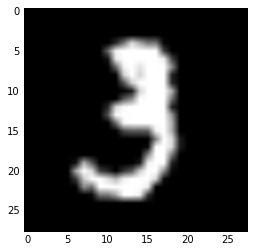

In [8]:
i = 10
print 'Label for image index {}: {}'.format(i, y_train[i])
print 'Image:'
plt.imshow(x_train[i][0], cmap=plt.cm.gray);

## Create the GAN model

In [9]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

### Generator

In [10]:
g_opt = Adam(lr=1e-4)

In [11]:
g_input_noise = Input(shape=[100])
g_input_label = Input(shape=[nb_classes])

g_input = merge([g_input_noise, g_input_label], mode='concat', concat_axis=1)

g = Dense(200*14*14, init='glorot_normal')(g_input)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Reshape([200, 14, 14])(g)
g = UpSampling2D(size=(2, 2))(g)

g = Convolution2D(100, 3, 3, border_mode='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Convolution2D(50, 3, 3, border_mode='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Convolution2D(1, 1, 1, border_mode='same', init='glorot_normal')(g)
g_output = Activation('sigmoid')(g)

generator = Model([g_input_noise, g_input_label], g_output)
generator.compile(loss='binary_crossentropy', optimizer=g_opt)

In [12]:
# generator.summary()

### Discriminator

In [13]:
d_opt = Adam(lr=1e-3)

In [130]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')

d_input_label = Input(shape=[10], name='label input')
d_input_label_2 = Reshape((10,1))(d_input_label)
d_input_label_2 = ZeroPadding1D(padding=(0,6))(d_input_label_2)
d_input_label_2 = Reshape((1,4,4))(d_input_label_2)
d_input_label_2 = UpSampling2D(size=(7,7))(d_input_label_2)

d_input = merge([d_input_img, d_input_label_2], mode='concat', concat_axis=1)

d = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(d_input)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [131]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
label input (InputLayer)         (None, 10)            0                                            
____________________________________________________________________________________________________
reshape_53 (Reshape)             (None, 10, 1)         0           label input[0][0]                
____________________________________________________________________________________________________
zeropadding1d_21 (ZeroPadding1D) (None, 16, 1)         0           reshape_53[0][0]                 
____________________________________________________________________________________________________
reshape_54 (Reshape)             (None, 1, 4, 4)       0           zeropadding1d_21[0][0]           
___________________________________________________________________________________________

### Stack Generator and Discriminator

In [132]:
make_trainable(discriminator, False)
# discriminator.trainable = False

In [133]:
gan_opt = Adam(lr=1e-4)

In [136]:
gan_input_noise = Input(shape=[100])
gan_input_label = Input(shape=[10])

gan_input = merge([g_input_noise, g_input_label], mode='concat', concat_axis=1)
g_output = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([g_output, gan_input_label])
gan = Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(loss='categorical_crossentropy', optimizer=gan_opt)

In [137]:
# gan.summary()

## Train GAN

### Pre train Discriminator

In [155]:
# Sample real images
n = 10000
idx = np.random.randint(0, x_train.shape[0], size=n)
real_images = x_train[idx, :, :, :]

In [156]:
# Generate fake images
noise = np.random.uniform(0, 1, size=[n, 100])
labels = np_utils.to_categorical(y_train[idx], nb_classes = 10)

In [157]:
noise.shape

(10000, 100)

In [158]:
labels.shape

(10000, 10)

In [159]:
fake_images = generator.predict([noise, labels], verbose=0)

In [160]:
# Combine real and fake images
x = np.concatenate((real_images, fake_images))
y = np.zeros([2*n, 2])
y[:n, 1] = 1  # set second feature of y to 1 for real images
y[n:, 0] = 1  # set first feature of y to 1 for fake images

In [161]:
labels_2 = np.concatenate((labels, labels))

In [162]:
x.shape

(20000, 1, 28, 28)

In [163]:
labels_2.shape

(20000, 10)

In [164]:
# Train the discriminator part of the network
make_trainable(discriminator, True)
# discriminator.trainable = True
discriminator.fit([x, labels_2], y, nb_epoch=1, batch_size=32, verbose=2)

Epoch 1/1
32s - loss: 0.0019


In [ ]:
# d_loss = discriminator.train_on_batch(x, y)
# print 'D loss: {}'.format(d_loss)

### Train

In [167]:
nb_epoch = 6000
batch_size = 32

Epoch 520 out of 6000
D loss: 1.19209303762e-07
GAN loss: 16.1180953979
Time elapsed in epoch 520: 0.40 seconds


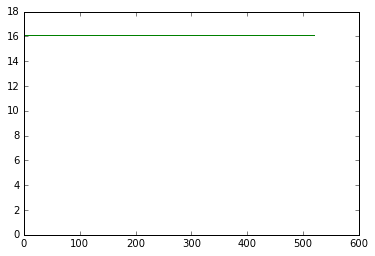

Fake image using label 6:


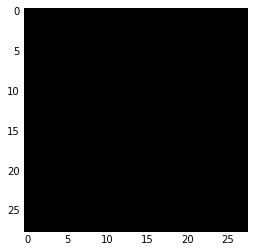

KeyboardInterrupt: 

In [168]:
d_losses, gan_losses = [], []
for epoch in range(nb_epoch):
    start_time = time.time()
    # Sample real images
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    real_images = x_train[idx, :, :, :]
    
    # Generate fake images
    noise = np.random.uniform(0, 1, size=[batch_size, 100])
    labels = np_utils.to_categorical(y_train[idx], nb_classes=10)
    fake_images = generator.predict([noise, labels])
    
    # Combine real and fake images
    x = np.concatenate((real_images, fake_images))
    y = np.zeros([2*batch_size, 2])
    y[:batch_size, 1] = 1  # set second feature of y to 1 for real images
    y[batch_size:, 0] = 1  # set first feature of y to 1 for fake images
    
    # Train the discriminator part of the network
#     discriminator.trainable = True
    labels_2 = np.concatenate((labels, labels))
    d_loss = discriminator.train_on_batch([x, labels_2], y)
    
    # Train the whole GAN network
    x = np.random.uniform(0, 1, size=[batch_size, 100])
    labels = np_utils.to_categorical(np.random.randint(0, 10, size=batch_size), nb_classes=10)
    y = np.zeros([batch_size, 2])
    y[:, 1] = 1
#     discriminator.trainable = False
    gan_loss = gan.train_on_batch([x, labels], y)
    d_losses += [d_loss]
    gan_losses += [gan_loss]
    
    if epoch % 20 == 0:  
        display.clear_output(wait=True)
        print 'Epoch {} out of {}'.format(epoch, nb_epoch)
        print 'D loss: {}'.format(d_loss)
        print 'GAN loss: {}'.format(gan_loss)
        print 'Time elapsed in epoch {}: {:.2f} seconds'.format(epoch, time.time()-start_time)
#         display.display(plt.gcf())
        plt.plot(d_losses);
        plt.plot(gan_losses);
        plt.legend();
        plt.show();
        
        # Sample fake image
        noise = np.random.uniform(0, 1, size=[1, 100])
        label = np.random.randint(0, 10)
        labels = np_utils.to_categorical(label, nb_classes=10)
        fake_images = generator.predict([noise, labels], verbose=0)
        print 'Fake image using label {}:'.format(label)
        plt.imshow(fake_images[0][0], cmap=plt.cm.gray);
        plt.show();

## Test GAN

Fake image using label 2:


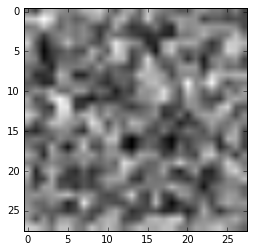

Fake image using label 6:


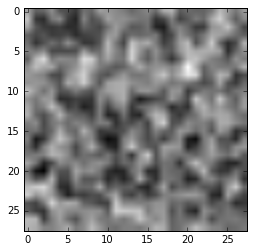

Fake image using label 1:


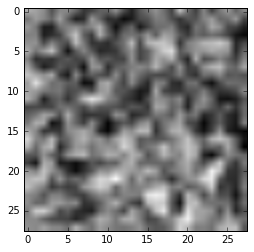

Fake image using label 5:


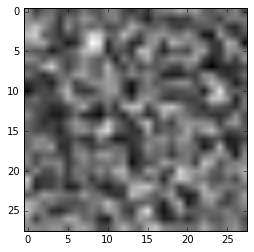

Fake image using label 7:


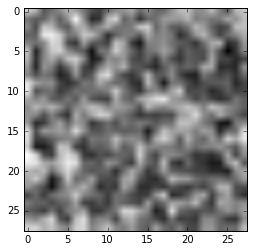

In [175]:
n = 5
def show_fake_images(n):
    noise = np.random.uniform(0, 1, size=[n, 100])
    label = np.random.randint(0, 10, size=n)
    labels = np_utils.to_categorical(label, nb_classes=10)
    fake_images = generator.predict([noise, labels], verbose=0)

    for img, label in zip(fake_images, labels):
        print 'Fake image using label {}:'.format(np.argmax(label))
        plt.imshow(img[0], cmap=plt.cm.gray);
        plt.show();